#Cuestiones generales

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Train set

Descargo y leo los csv

In [ ]:
id = '1VvZp2MML5dLce79TMsrCQm5VkvQn93zN'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_identity.csv')

train_identity = pd.read_csv('train_identity.csv')

In [ ]:
id = '18ZAaojp_783CfnqhNj43w1vgwZOH221D'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_transaction.csv')

train_transaction = pd.read_csv('train_transaction.csv')

Mergeo los dos datasets que tengo

In [ ]:
df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [ ]:
df.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,272.0,87.0,36.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,debit,126.0,87.0,0.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,NaN,NaN,mail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,debit,337.0,87.0,NaN,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,debit,204.0,87.0,19.0,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0,61.0,61.0,30.0,318.0,30.0

Limpio la RAM

In [ ]:
train_transaction = None
train_identity = None
downloaded = None

#Validation set

Dejo un 30% del dataset original como validation set

In [ ]:
len(df.index)

590540

In [ ]:
validation = df.loc[0:(0.3 * len(df.index)), :]

In [ ]:
len(validation.index)

177163

In [ ]:
train = df.loc[(0.3 * len(df.index)):len(df.index), :]

In [ ]:
len(train.index)

413378

In [ ]:
train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
177162,3164162,0,3864166,39.00,W,10447,490.0,150.0,visa,226.0,debit,315.0,87.0,NaN,NaN,yahoo.com,NaN,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,1.0,182.0,182.0,6.0,182.0,6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177163,3164163,1,3864195,49.00,W,1802,555.0,150.0,visa,226.0,debit,170.0,87.0,NaN,NaN,gmail.com,NaN,2.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,4.0,0.0,3.0,1.0,3.0,3.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177164,3164164,0,3864205,102.00,W,2114,396.0,150.0,mastercard,224.0,debit,315.0,87.0,NaN,NaN,NaN,NaN,13.0,20.0,0.0,0.0,1.0,6.0,0.0,0.0,9.0,0.0,9.0,0.0,53.0,10.0,6.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177165,3164165,1,3864212,24.00,W,10057,225.0,150.0,mastercard,224.0,debit,269.0,87.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177166,3164166,0,3864218,422.50,W,16659,170.0,150.0,visa,226.0,credit,264.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177167,3164167,0,3864222,25.95,W,13052,254.0,150.0,visa,226.0,debit,325.0,87.0,NaN,NaN,gmail.com,NaN,4.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,3.0,0.0,22.0,4.0,121.0,121.0,12.0,158.0,12.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177168,3164168,0,3864228,221.99,W,13864,561.0,150.0,visa,226.0,debit,123.0,87.0,NaN,NaN,gmail.com,NaN,2.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,48.0,48.0,48.0,48.0,48.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177169,3164169,0,3864242,35.95,W,4501,390.0,150.0,mastercard,224.0,debit,498.0,87.0,NaN,NaN,gmail.com,NaN,83.0,67.0,0.0,0.0,188.0,50.0,0.0,0.0,58.0,0.0,63.0,0.0,488.0,68.0,102.0,102.0,7.0,338.0,21.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177170,3164170,0,3864249,117.00,W,9500,321.0,150.0,visa,226.0,debit,325.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,NaN,NaN,282.0,282.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177171,3164171,0,3864277,209.95,W,7826,481.0,150.0,mastercard,224.0,debit,494.0,87.0,4.0,NaN,NaN,NaN,154.0,135.0,0.0,0.0,145.0,105.0,0.0,0.0,92.0,0.0,106.0,0.0,477.0,123.0,53.0,53.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
validation.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,272.0,87.0,36.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,debit,126.0,87.0,0.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,NaN,NaN,mail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,debit,337.0,87.0,NaN,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,debit,204.0,87.0,19.0,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0,61.0,61.0,30.0,318.0,30.0

In [ ]:
columnas_train = train.columns

Limpio la RAM

In [ ]:
df = None

#Encoding train y validation set

In [ ]:
from sklearn.preprocessing import OneHotEncoder

Diccionario en el que guardo como claves las columnas y como valores una lista de la forma [encoder, mean]

In [ ]:
dic = {}

In [ ]:
for c in train.columns:
  if c == 'isFraud': #a la columna isFraud no la toco
      continue

  if c == 'id_31': #aplico CountVectorizer a la columna id_30
      from sklearn.feature_extraction.text import CountVectorizer
      vectorizer = CountVectorizer(max_features=7)
      train[c].fillna(' ', inplace=True)
      vectorizer.fit(train.id_31)

      feature = vectorizer.transform(train.id_31).toarray()
      new_df = pd.DataFrame(feature, columns=vectorizer.get_feature_names(), index=train.index)
      train = pd.concat([train, new_df], axis=1).drop(columns=[c])

      validation[c].fillna(' ', inplace=True)
      feature = vectorizer.transform(validation.id_31).toarray()
      new_df = pd.DataFrame(feature, columns=vectorizer.get_feature_names(), index=validation.index)
      validation = pd.concat([validation, new_df], axis=1).drop(columns=[c])

      dic[c] = [vectorizer, None]

      vectorizer = None
      feature = None
      feature_labels = None
      new_df = None

      continue


  if c == 'DeviceType': #aplico OneHotEncoding a las columnas ProductCD y card4
      ohe = OneHotEncoder()
      ohe.fit(train[[c]])

      feature = ohe.transform(train[[c]]).toarray()
      new_df = pd.DataFrame(feature, columns=ohe.categories_, index=train.index)
      train = pd.concat([train, new_df], axis=1).drop(columns=[c])

      feature = ohe.transform(validation[[c]]).toarray()
      new_df = pd.DataFrame(feature, columns=ohe.categories_, index=validation.index)
      validation = pd.concat([validation, new_df], axis=1).drop(columns=[c])

      dic[c] = [ohe, None]

      ohe = None
      feature = None
      feature_labels = None
      new_df = None

      continue

  if (train[c].dtype.kind not in 'biufc'): #aplico MeanEncoding al resto de las columnas no numéricas
      mean_encoded_subject = train.groupby(c)['isFraud'].mean().to_dict()

      train[c] =  train[c].map(mean_encoded_subject)
      validation[c] = validation[c].map(mean_encoded_subject)

      dic[c] = [mean_encoded_subject, train[c].mean()]

  aux = train[c].mean()
  train[c].fillna(aux, inplace=True)
  validation[c].fillna(aux, inplace=True)
  if c not in dic:
    dic[c] = [None, aux]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceInfo,65,android,chrome,for,generic,mobile,safari,"(desktop,)","(mobile,)","(nan,)"
177162,3164162,0,3864166,39.00,0.021053,10447,490.0,150.0,0.038016,226.0,0.025510,315.0,87.0,116.06686,226.707442,0.025593,0.107195,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,1.0,182.0,182.000000,6.000000,182.000000,6.000000,75.469764,37.282984,131.031119,0.553722,...,0.070348,-0.274654,99.773942,0.108306,48.518003,-339.278514,0.109691,0.110087,196.754465,14.379886,349.094953,416.232534,367.312224,16.509919,0.1205,12.635556,332.540971,148.895105,0.1205,0.109648,0.109648,0.075285,26.216168,0.07671,0.075925,0.109691,0.109691,0.109691,0.109691,0.104684,0,0,0,0,0,0,0,0.0,0.0,1.0
177163,3164163,1,3864195,49.00,0.021053,1802,555.0,150.0,0.038016,226.0,0.025510,170.0,87.0,116.06686,226.707442,0.045380,0.107195,2.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,4.0,0.0,3.0,1.0,3.0,3.000000,0.000000,2.000000,0.000000,75.469764,37.282984,131.031119,0.553722,...,0.070348,-0.274654,99.773942,0.108306,48.518003,-339.278514,0.109691,0.110087,196.754465,14.379886,349.094953,416.232534,367.312224,16.509919,0.1205,12.635556,332.540971,148.895105,0.1205,0.109648,0.109648,0.075285,26.216168,0.07671,0.075925,0.109691,0.109691,0.109691,0.109691,0.104684,0,0,0,0,0,0,0,0.0,0.0,1.0
177164,3164164,0,3864205,102.00,0.021053,2114,396.0,150.0,0.035411,224.0,0.025510,315.0,87.0,116.06686,226.707442,0.038933,0.107195,13.0,20.0,0.0,0.0,1.0,6.0,0.0,0.0,9.0,0.0,9.0,0.0,53.0,10.0,6.0,6.000000,0.000000,144.315713,42.567771,75.469764,37.282984,131.031119,0.553722,...,0.070348,-0.274654,99.773942,0.108306,48.518003,-339.278514,0.109691,0.110087,196.754465,14.379886,349.094953,416.232534,367.312224,16.509919,0.1205,12.635556,332.540971,148.895105,0.1205,0.109648,0.109648,0.075285,26.216168,0.07671,0.075925,0.109691,0.109691,0.109691,0.109691,0.104684,0,0,0,0,0,0,0,0.0,0.0,1.0
177165,3164165,1,3864212,24.00,0.021053,10057,225.0,150.0,0.035411,224.0,0.025510,269.0,87.0,116.06686,226.707442,0.038933,0.107195,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,2.000000,1.000000,144.315713,42.567771,75.469764,37.282984,131.031119,0.553722,...,0.070348,-0.274654,99.773942,0.108306,48.518003,-339.278514,0.109691,0.110087,196.754465,14.379886,349.094953,416.232534,367.312224,16.509919,0.1205,12.635556,332.540971,148.895105,0.1205,0.109648,0.109648,0.075285,26.216168,0.07671,0.075925,0.109691,0.109691,0.109691,0.109691,0.104684,0,0,0,0,0,0,0,0.0,0.0,1.0
177166,3164166,0,3864218,422.50,0.021053,16659,170.0,150.0,0.038016,226.0,0.080659,264.0,87.0,116.06686,226.707442,0.045380,0.107195,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,171.361941,28.115415,0.000000,42.567771,75.469764,37.282984,131.031119,0.553722,...,0.070348,-0.274654,99.773942,0.108306,48.518003,-339.278514,0.109691,0.110087,196.754465,14.379886,349.094953,416.232534,367.312224,16.509919,0.1205,12.635556,332.540971,148.895105,0.1205,0.109648,0.109648,0.075285,26.216168,0.07671,0.075925,0.109691,0.109691,0.109691,0.109691,0.104684,0,0,0,0,0,0,0,0.0,0.0,1.0
177167,3164167,0,3864222,25.95,0.021053,13052,254.0,150.0,0.038016,226.0,0.025510,325.0,87.0,116.06686,226.707442,0.045380,0.107195,4.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,3.0,0.0,22.0,4.0,121.0,121.000000,12.000000,158.000000,12.000000,75.469764,37.282984,131.031119,0.553722,...,0.070348,-0.274654,99.773942,0.108306,48.518003,-339.278514,0.109691,0.110087,196.754465,14.379886,349.094953,416.232534,367.312224,16.509919,0.1205,12.635556,332.540971,148.895105,0.1205,0.109648,0.109648,0.075285,26.216168,0.07671,0.075925,0.109691,0.109691,0.109691,0.109691,0.104

In [ ]:
validation.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceInfo,65,android,chrome,for,generic,mobile,safari,"(desktop,)","(mobile,)","(nan,)"
0,2987000,0,86400,68.5,0.021053,13926,360.037841,150.0,0.099141,142.0,0.080659,315.0,87.0,19.00000,226.707442,0.038933,0.107195,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,171.361941,13.000000,144.315713,42.567771,75.469764,37.282984,131.031119,0.553722,...,0.070348,-0.274654,99.773942,0.108306,48.518003,-339.278514,0.109691,0.110087,196.754465,14.379886,349.094953,416.232534,367.312224,16.509919,0.1205,12.635556,332.540971,148.895105,0.1205,0.109648,0.109648,0.075285,26.216168,0.076710,0.075925,0.109691,0.109691,0.109691,0.109691,0.104684,0,0,0,0,0,0,0,0.0,0.0,1.0
1,2987001,0,86401,29.0,0.021053,2755,404.000000,150.0,0.035411,102.0,0.080659,325.0,87.0,116.06686,226.707442,0.045380,0.107195,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,171.361941,28.115415,0.000000,42.567771,75.469764,37.282984,131.031119,0.553722,...,0.070348,-0.274654,99.773942,0.108306,48.518003,-339.278514,0.109691,0.110087,196.754465,14.379886,349.094953,416.232534,367.312224,16.509919,0.1205,12.635556,332.540971,148.895105,0.1205,0.109648,0.109648,0.075285,26.216168,0.076710,0.075925,0.109691,0.109691,0.109691,0.109691,0.104684,0,0,0,0,0,0,0,0.0,0.0,1.0
2,2987002,0,86469,59.0,0.021053,4663,490.000000,150.0,0.038016,166.0,0.025510,330.0,87.0,287.00000,226.707442,0.102670,0.107195,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,171.361941,28.115415,0.000000,42.567771,75.469764,37.282984,131.031119,0.553722,...,0.070348,-0.274654,99.773942,0.108306,48.518003,-339.278514,0.109691,0.110087,196.754465,14.379886,349.094953,416.232534,367.312224,16.509919,0.1205,12.635556,332.540971,148.895105,0.1205,0.109648,0.109648,0.075285,26.216168,0.076710,0.075925,0.109691,0.109691,0.109691,0.109691,0.104684,0,0,0,0,0,0,0,0.0,0.0,1.0
3,2987003,0,86499,50.0,0.021053,18132,567.000000,150.0,0.035411,117.0,0.025510,476.0,87.0,116.06686,226.707442,0.025593,0.107195,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.000000,0.000000,94.000000,0.000000,75.469764,37.282984,131.031119,0.553722,...,0.070348,-0.274654,99.773942,0.108306,48.518003,-339.278514,0.109691,0.110087,196.754465,14.379886,349.094953,416.232534,367.312224,16.509919,0.1205,12.635556,332.540971,148.895105,0.1205,0.109648,0.109648,0.075285,26.216168,0.076710,0.075925,0.109691,0.109691,0.109691,0.109691,0.104684,0,0,0,0,0,0,0,0.0,0.0,1.0
4,2987004,0,86506,50.0,0.095829,4497,514.000000,150.0,0.035411,102.0,0.080659,420.0,87.0,116.06686,226.707442,0.045380,0.107195,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,171.361941,28.115415,144.315713,42.567771,75.469764,37.282984,131.031119,0.553722,...,0.070348,-0.274654,100.000000,0.114087,48.518003,-480.000000,0.071957,0.071221,166.000000,14.379886,542.000000,144.000000,367.312224,16.509919,0.1205,12.635556,332.540971,148.895105,0.1205,0.072922,0.072281,0.133484,32.000000,0.092105,0.067213,0.075777,0.111923,0.113097,0.080204,0.000000,0,0,0,0,0,0,0,0.0,1.0,0.0
5,2987005,0,86510,49.0,0.021053,5937,555.000000,150.0,0.038016,226.0,0.025510,272.0,87.0,36.00000,226.707442,0.045380,0.107195,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,171.361941,28.115415,0.000000,42.567771,75.469764,37.282984,131.031119,0.553722,...,0.070348,-0.274654,99.773942,0.108306,48.518003,-339.278514,0.109691,0.110087,196.754465,14.379886,349.094953,416.232534,367.312224,16.509919,0.1205,12.635556,332.540971,148.895105,0.1205,0.109648,0.109648,0.075285,26.216168,0.076710,0.075925,0.109691,0.109691,0.109691,0.109691,0.104684,0,0,0,0,0,0

#Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
points_train = train.drop(columns=['isFraud'])
labels_train = pd.DataFrame(train['isFraud'])

In [ ]:
selector = SelectKBest(f_regression, k=100)

In [ ]:
selector.fit(points_train, labels_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SelectKBest(k=100, score_func=<function f_regression at 0x7fa1bd210680>)

In [ ]:
cols = selector.get_support(indices=True)

In [ ]:
cols

array([  3,   6,   9,  15,  22,  27,  48,  68,  69,  70,  71,  74,  75,
        76,  84,  85,  86,  87,  90,  91,  92,  93,  95,  96,  97,  98,
       100, 103, 104, 105, 110, 111, 112, 113, 116, 117, 124, 125, 126,
       127, 130, 131, 132, 133, 134, 137, 138, 139, 140, 145, 146, 147,
       164, 166, 176, 202, 209, 211, 223, 224, 229, 239, 241, 242, 243,
       244, 247, 250, 252, 253, 254, 274, 275, 281, 282, 283, 295, 296,
       297, 298, 299, 300, 301, 302, 305, 307, 310, 311, 312, 315, 335,
       336, 355, 356, 357, 430, 432, 433, 439, 440])

In [ ]:
cont = -1
for c in points_train.columns:
  cont += 1
  if cont not in cols and c not in ['id_33', 'DeviceInfo', 'isFraud']:
    train.drop(columns=[c], inplace=True)

In [ ]:
train.head()

,isFraud,ProductCD,card3,card6,R_emaildomain,C7,C12,M4,V15,V16,V17,V18,V21,V22,V23,V31,V32,V33,V34,V37,V38,V39,V40,V42,V43,V44,V45,V47,V50,V51,V52,V57,V58,V59,V60,V63,V64,V71,V72,V73,...,V186,V188,V189,V190,V191,V194,V197,V199,V200,V201,V221,V222,V228,V229,V230,V242,V243,V244,V245,V246,V247,V248,V249,V252,V254,V257,V258,V259,V262,V282,V283,V302,V303,V304,id_33,DeviceInfo,android,chrome,"(mobile,)","(nan,)"
177162,0,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.028990,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,0.0,0.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0
177163,1,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.037299,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.000000,2.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,2.0,6.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0
177164,0,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.028990,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.103761,1.158857,0.146788,0.157945,0.13775,0.150655,1.084039,1.120623,1.035898,0.143738,0.158898,0.172663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,2.0,13.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0
177165,1,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.037299,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.103761,1.158857,0.146788,0.157945,0.13775,0.150655,1.084039,1.120623,1.035898,0.143738,0.158898,0.172663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,3.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0
177166,0,0.021053,150.0,0.080659,0.107195,0.0,0.0,0.037299,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,1.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0


In [ ]:
#aux1 = train['id_33']
#aux2 = train['DeviceInfo']
#aux3 = train['isFraud']
#new_train = train.iloc[:,cols]
##new_train['id_31'] = train['id_31']
#new_train['id_33'] = train['id_33']
##new_train['DeviceType'] = train['DeviceType']
#new_train['DeviceInfo'] = train['DeviceInfo']
#new_train['isFraud'] = train['isFraud']

In [ ]:
cont = -1
for c in points_train.columns:
  cont += 1
  if cont not in cols and c not in ['id_33', 'DeviceInfo', 'isFraud']:
    validation.drop(columns=[c], inplace=True)

In [ ]:
#new_validation = validation.iloc[:,cols]
##new_validation['id_31'] = validation['id_31']
#new_validation['id_33'] = validation['id_33']
##new_validation['DeviceType'] = validation['DeviceType']
#new_validation['DeviceInfo'] = validation['DeviceInfo']
#new_validation['isFraud'] = validation['isFraud']

In [ ]:
validation.head()

,isFraud,ProductCD,card3,card6,R_emaildomain,C7,C12,M4,V15,V16,V17,V18,V21,V22,V23,V31,V32,V33,V34,V37,V38,V39,V40,V42,V43,V44,V45,V47,V50,V51,V52,V57,V58,V59,V60,V63,V64,V71,V72,V73,...,V186,V188,V189,V190,V191,V194,V197,V199,V200,V201,V221,V222,V228,V229,V230,V242,V243,V244,V245,V246,V247,V248,V249,V252,V254,V257,V258,V259,V262,V282,V283,V302,V303,V304,id_33,DeviceInfo,android,chrome,"(mobile,)","(nan,)"
0,0,0.021053,150.0,0.080659,0.107195,0.0,0.0,0.123225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.103761,1.158857,0.146788,0.157945,0.13775,0.150655,1.084039,1.120623,1.035898,0.143738,0.158898,0.172663,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,1.0,0.0,0.0,0.0,0.076710,0.104684,0,0,0.0,1.0
1,0,0.021053,150.0,0.080659,0.107195,0.0,0.0,0.037299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,1.0,0.0,0.0,0.0,0.076710,0.104684,0,0,0.0,1.0
2,0,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.037299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,1.0,0.0,0.0,0.0,0.076710,0.104684,0,0,0.0,1.0
3,0,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.037299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,0.0,0.0,0.0,0.0,0.0,0.076710,0.104684,0,0,0.0,1.0
4,0,0.095829,150.0,0.080659,0.107195,0.0,0.0,0.051507,0.114853,0.115119,0.125419,0.126085,0.121369,0.123789,1.034559,0.129383,0.130101,0.126064,0.136202,1.103761,1.158857,0.146788,0.157945,0.13775,0.150655,1.084039,1.120623,1.035898,0.143738,0.158898,0.172663,0.11812,0.122731,0.125129,0.133835,0.12177,0.133793,0.128688,0.133586,0.132513,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,0.092105,0.000000,0,0,1.0,0.0


In [ ]:
points_train = None
points_label = None
selector = None

#Hiperparámetros

In [ ]:
points_train = train.drop(columns=['isFraud'])
labels_train = pd.DataFrame(train['isFraud'])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb = GradientBoostingClassifier(random_state=7)

In [ ]:
parametros = [{
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [2, 3, 4, 5, 6],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [100, 400, 700, 1000, 1300, 1700, 2000]
}]

In [ ]:
model = RandomizedSearchCV(gb, param_distributions=parametros, n_iter=20, random_state=7, scoring='roc_auc', n_jobs=1, verbose=100, cv=2)

In [ ]:
model.fit(points_train, labels_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV 1/2; 1/20] START learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 1/20] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.831 total time=   7.4s
[CV 2/2; 1/20] START learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 1/20] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.815 total time=   7.0s
[CV 1/2; 2/20] START learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 2/20] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=700;, score=nan total time=   0.3s
[CV 2/2; 2/20] START learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 2/20] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=700;, score=nan total time=   0.3s
[CV 1/2; 3/20] START learning_rate=0.1, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 3/20] END learning_rate=0.1, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1700;, score=0.837 total time= 2.6min
[CV 2/2; 3/20] START learning_rate=0.1, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 3/20] END learning_rate=0.1, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1700;, score=0.835 total time= 2.7min
[CV 1/2; 4/20] START learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 4/20] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700;, score=0.791 total time= 1.8min
[CV 2/2; 4/20] START learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 4/20] END learning_rate=0.3, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700;, score=0.801 total time= 1.7min
[CV 1/2; 5/20] START learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 5/20] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.852 total time=  15.9s
[CV 2/2; 5/20] START learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 5/20] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.844 total time=  15.3s
[CV 1/2; 6/20] START learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=1, n_estimators=400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 6/20] END learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=1, n_estimators=400;, score=nan total time=   0.3s
[CV 2/2; 6/20] START learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=1, n_estimators=400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 6/20] END learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=1, n_estimators=400;, score=nan total time=   0.3s
[CV 1/2; 7/20] START learning_rate=0.1, max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 7/20] END learning_rate=0.1, max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=700;, score=0.827 total time= 1.6min
[CV 2/2; 7/20] START learning_rate=0.1, max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 7/20] END learning_rate=0.1, max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=700;, score=0.836 total time= 1.5min
[CV 1/2; 8/20] START learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 8/20] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=400;, score=nan total time=   0.3s
[CV 2/2; 8/20] START learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 8/20] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=400;, score=nan total time=   0.3s
[CV 1/2; 9/20] START learning_rate=0.2, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 9/20] END learning_rate=0.2, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.848 total time= 1.4min
[CV 2/2; 9/20] START learning_rate=0.2, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 9/20] END learning_rate=0.2, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.841 total time= 1.4min
[CV 1/2; 10/20] START learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 10/20] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=100;, score=nan total time=   0.4s
[CV 2/2; 10/20] START learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 10/20] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=100;, score=nan total time=   0.4s
[CV 1/2; 11/20] START learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 11/20] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=700;, score=0.852 total time=  56.2s
[CV 2/2; 11/20] START learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 11/20] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=700;, score=0.845 total time=  55.2s
[CV 1/2; 12/20] START learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 12/20] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=700;, score=0.851 total time=  56.5s
[CV 2/2; 12/20] START learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 12/20] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=700;, score=0.845 total time=  53.2s
[CV 1/2; 13/20] START learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=1700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 13/20] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=1700;, score=0.750 total time= 3.3min
[CV 2/2; 13/20] START learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=1700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 13/20] END learning_rate=0.3, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=1700;, score=0.773 total time= 3.1min
[CV 1/2; 14/20] START learning_rate=0.3, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 14/20] END learning_rate=0.3, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=2000;, score=nan total time=   0.3s
[CV 2/2; 14/20] START learning_rate=0.3, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 14/20] END learning_rate=0.3, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=2000;, score=nan total time=   0.3s
[CV 1/2; 15/20] START learning_rate=0.1, max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 15/20] END learning_rate=0.1, max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=400;, score=nan total time=   0.3s
[CV 2/2; 15/20] START learning_rate=0.1, max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 15/20] END learning_rate=0.1, max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=400;, score=nan total time=   0.3s
[CV 1/2; 16/20] START learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 16/20] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=2000;, score=nan total time=   0.3s
[CV 2/2; 16/20] START learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 16/20] END learning_rate=0.3, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=2000;, score=nan total time=   0.3s
[CV 1/2; 17/20] START learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 17/20] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=100;, score=nan total time=   0.3s
[CV 2/2; 17/20] START learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/2; 17/20] END learning_rate=0.2, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=100;, score=nan total time=   0.3s
[CV 1/2; 18/20] START learning_rate=0.2, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 18/20] END learning_rate=0.2, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.851 total time=  10.8s
[CV 2/2; 18/20] START learning_rate=0.2, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 18/20] END learning_rate=0.2, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.839 total time=   9.8s
[CV 1/2; 19/20] START learning_rate=0.3, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 19/20] END learning_rate=0.3, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=0.848 total time= 2.9min
[CV 2/2; 19/20] START learning_rate=0.3, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 19/20] END learning_rate=0.3, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=0.838 total time= 2.8min
[CV 1/2; 20/20] START learning_rate=0.1, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 20/20] END learning_rate=0.1, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=0.805 total time=27.1min
[CV 2/2; 20/20] START learning_rate=0.1, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 20/20] END learning_rate=0.1, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=0.821 total time=26.2min


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
16 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 596, in fit
    monitor,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 672, in _fit_stages
    X_csr,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 246, in _fit_stage
    tree.

RandomizedSearchCV(cv=2, estimator=GradientBoostingClassifier(random_state=7),
                   n_iter=20, n_jobs=1,
                   param_distributions=[{'learning_rate': [0.1, 0.2, 0.3],
                                         'max_depth': [2, 3, 4, 5, 6],
                                         'max_features': ['auto', 'sqrt',
                                                          'log2'],
                                         'min_samples_leaf': [1, 2, 3],
                                         'min_samples_split': [1, 2, 3],
                                         'n_estimators': [100, 400, 700, 1000,
                                                          1300, 1700, 2000]}],
                   random_state=7, scoring='roc_auc', verbose=100)

In [ ]:
model.best_estimator_

GradientBoostingClassifier(max_features='log2', min_samples_leaf=2,
                           n_estimators=700, random_state=7)

#Gradient Boosting Classifier

In [ ]:
points_train = train.drop(columns=['isFraud'])
labels_train = pd.DataFrame(train['isFraud'])

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb = model.best_estimator_#GradientBoostingClassifier(max_depth=2, max_features='sqrt', n_estimators=1300, random_state=13)

In [ ]:
gb.fit(points_train, labels_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(max_features='log2', min_samples_leaf=2,
                           n_estimators=700, random_state=7)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
points_validation = validation.drop(columns=['isFraud'])
labels_validation = pd.DataFrame(validation['isFraud'])

In [ ]:
roc_auc_score(labels_validation, gb.predict_proba(points_validation)[:, 1])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


0.825782262714837

#Importancia features

In [ ]:
feature_importance = pd.DataFrame(gb.feature_importances_, index=points_train.columns, columns=['importance']).sort_values('importance', ascending=False)

In [ ]:
feature_importance.head(10)

,importance
DeviceInfo,0.139432
V246,0.067163
C12,0.062376
V86,0.044741
C7,0.041019
V257,0.037102
V258,0.034083
V283,0.032923
R_emaildomain,0.031839
V230,0.030798


Text(0.5, 1.0, 'Los 10 features más importantes')

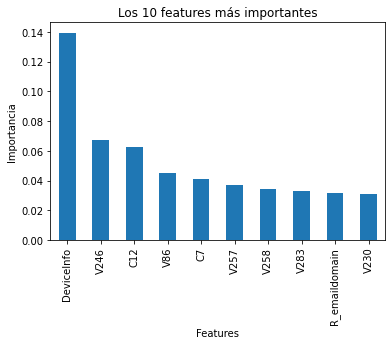

In [ ]:
feature_importance.head(10)['importance'].plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Los 10 features más importantes')

Hay algunos features que se repiten con respecto a la parte 2 (como por ejemplo C7 y C12) pero hay otros que se agregan (como por ejemplo DeviceInfo y R_emaildomain)

In [ ]:
feature_importance = None

#Matriz de confusión

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [ ]:
conf_matrix = confusion_matrix(labels_validation, gb.predict(points_validation))
conf_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


array([[171170,    967],
       [  3401,   1625]])

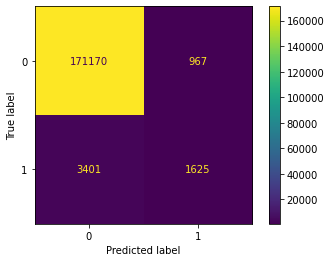

In [ ]:
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()

In [ ]:
conf_matrix = None
disp = None